# Prosper Loan Data Investigation Findings
## by Abanoub Aziz

## Investigation Overview

> This presentation is made to outline the factors that I have found to have an affect on whether a borrower will default on a loan or pay it in full.

## Dataset Overview

* This data set contains 113,937 loans with 81 variables on each loan, including loan amount, borrower rate (or interest rate), current loan status, borrower income, and many others supplied by a credit company called Propser. Prosper or Prosper Marketplace Inc. is a San Francisco, California based company specializing in loans at low interest rates to the borrowers.
* For the purporse of this investigation I will be considering the following variables:

>Term, LoanStatus, BorrowerRate, ProsperRating (Alpha), ProsperScore, ListingCategory (numeric), BorrowerState, EmploymentStatus, DelinquenciesLast7Years, StatedMonthlyIncome, LoanOriginalAmount, LoanOriginationDate

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe and wrangling process
df = pd.read_csv("prosperLoanData.csv")
# First we create a list with the variables we are intrested in
sub_set = ['Term', 'LoanStatus', 'BorrowerRate', 'ProsperRating (Alpha)', 'ProsperScore', 'ListingCategory (numeric)', 
           'BorrowerState', 'EmploymentStatus', 'DelinquenciesLast7Years', 'StatedMonthlyIncome', 
           'LoanOriginalAmount', 'LoanOriginationDate']

# Then we filter the dataframe using the dataframe method to create a new dataframe with only the variables of intrest
df_sub = df[sub_set]
# Dropping the null values and checking if we have any remaining null values
df_sub = df_sub.dropna(subset = ['ProsperRating (Alpha)'])
# Converting the datatype of 'LoanOriginationDate' to datetime using pandas
df_sub['LoanOriginationDate'] = pd.to_datetime(df_sub['LoanOriginationDate'])
# We need to calculate the mean and standard deviations of the "StatedMonthlyIncome" variable
income_mean = df_sub.StatedMonthlyIncome.mean()
income_std = df_sub.StatedMonthlyIncome.std()
# 3 standard deviations of the mean
income_max = income_mean + 3*income_std
# Remove the datapoints with outliers in the StatedMonthlyIncome variable
df_sub2 = df_sub[df_sub['StatedMonthlyIncome'] < income_max]
# I will be ignoring the current loans, loans where the final payment is in progress and
# any loans with Past Due of less than 120 days
# since the data is incomplete (we don't know if the loan is going to be defaulted on or completed)
df_sub2 = df_sub2[(df_sub2['LoanStatus'] == 'Completed') | (df_sub2['LoanStatus'] == 'Chargedoff')
                  | (df_sub2['LoanStatus'] == 'Defaulted')]
# The previous graph does not constitute a good view of the data since most of the it is in
# "Debt Consolidation", "Other", "Home Improvement" and "Business"
# Thus a futher data wrangling step is required here, where we remove the other Categories
df_sub3 = df_sub2[(df_sub2['ListingCategory (numeric)'] == 1 ) | (df_sub2['ListingCategory (numeric)'] == 3 ) |
                  (df_sub2['ListingCategory (numeric)'] == 2 ) | (df_sub2['ListingCategory (numeric)'] == 7 )]
# Dictionary with the categories we are intrested in showing
cat_dict = {1: 'Debt Consolidation', 2: 'Home Improvement', 3: 'Business', 7: 'Other'}
df_sub3['ListingCategory'] = df_sub3['ListingCategory (numeric)'].map(cat_dict)
# Setting the default color palette
base_color = sb.color_palette()[0]

> Note that the above cells have been set as "Skip"-type slides. That means
that when the notebook is rendered as http slides, those cells won't show up.

## Distribution of the status of loans provided by Prosper

> This plot shows the disripution of the loan status after wrangling the data to remove variables that we were not interested in and since Prosper were not using their Rating system before 2019, this meant that we have rows of data with empty values that we can't interpolate, and I have chosen to drop these rows.
> Looking at the plot we can see that most of the loans are still current and yet to be paid in full or get defaulted on, the second most state of the loans is completed and paid in full, and the third and fourth are chargedoff and defaulted on respectively.

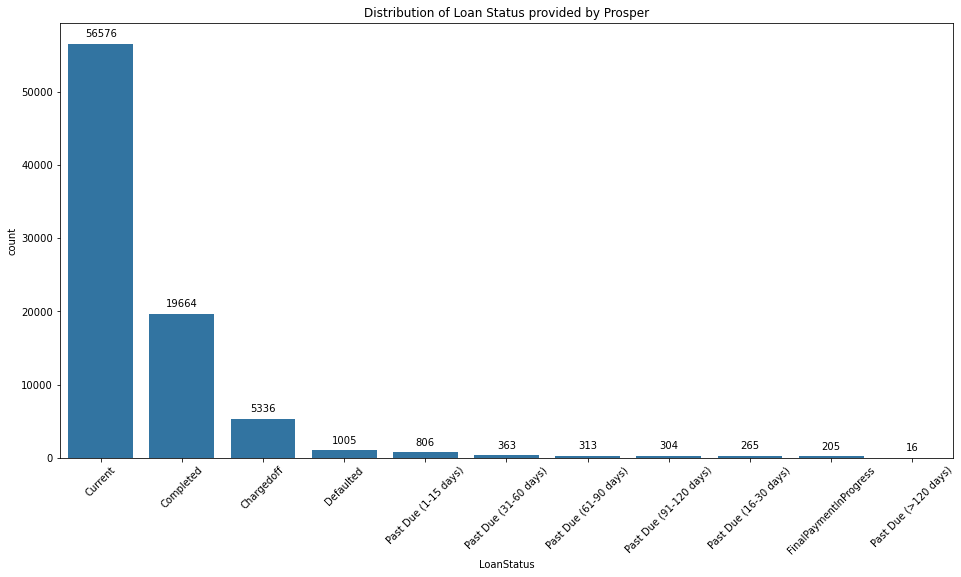

In [3]:
freq_status = df_sub['LoanStatus'].value_counts()
status_order = freq_status.index
plt.figure(figsize=[16, 8])
plt.xticks(rotation=45)
sb.countplot(data = df_sub, x = 'LoanStatus', color = base_color, order = status_order);
for i in range (freq_status.shape[0]):
    count = freq_status[i]
    plt.text(i, count+2000, count, ha = 'center', va='top')
plt.title('Distribution of Loan Status provided by Prosper');

## Effect on State on Loan Status

> Here we can see that borrower from California are most likley to default on loan payments, followed by Florida and New York while borrowers from Kansas are most likely to complete their loan payments.

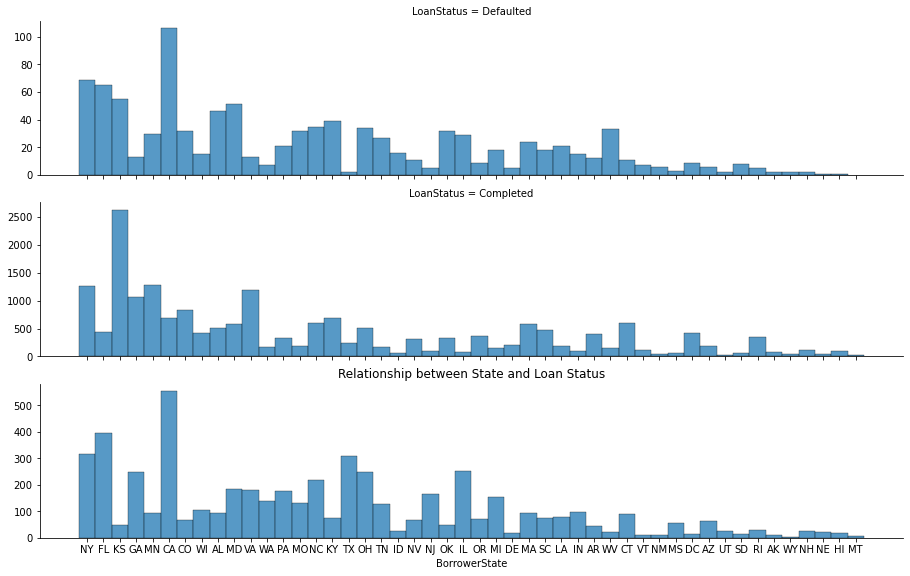

In [4]:
def mapsize(g, x, y):
    """Function to change the width, height for a plot where g is the plot, x is the width and y is the height"""
    g.fig.set_figwidth(x);
    g.fig.set_figheight(y);

g = sb.FacetGrid(data = df_sub2, col = 'LoanStatus', col_wrap = 1, sharey = False)
g.map(sb.histplot, "BorrowerState")
mapsize(g, 16, 8)
plt.title('Relationship between State and Loan Status');

## Effect of Loan Reason on Loan Status

> Here we can see that the proprtion for defaulting increases for Business (9.7% to 12.1%) and decreases for Home Improvement loans (11.7% to 9.8%) and for a similar result also occurs for the ChargedOff loans in which the proportaions increases for Business loans (9.7% to 13.1%) and decreases slightly for Home Improvement loans (11.7% to 11.5%)

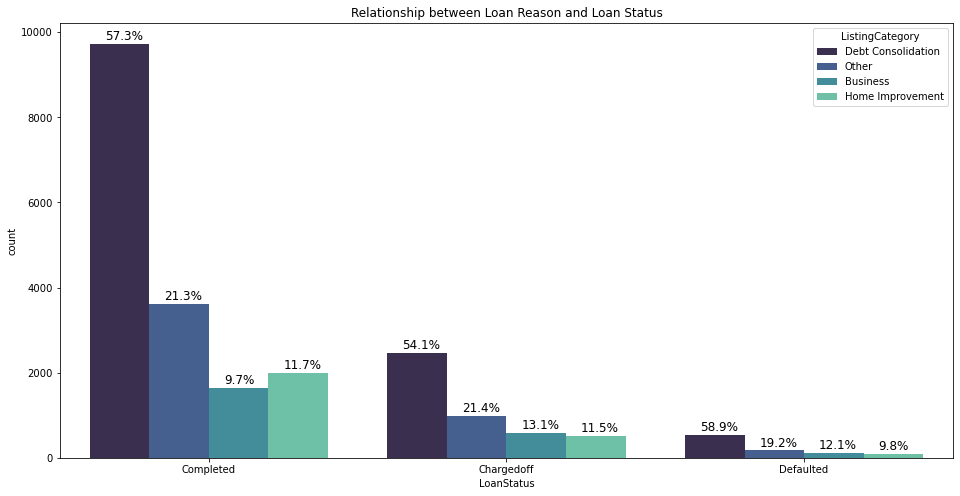

In [5]:
# Ploting the graph again using the filtered data and creating a function to write the proportion percentage on top of each bar

def print_proportion(plot, x, y):
    """Function to write the proportion percentage on top of each bar on the countplot graphs,
    x values needs to be in decending order for the function to work correctly,
    plot is the name of the graph variable, 
    x is the variable that we are categorizing for in the x axis,
    y is the variable that we are categorizing for in the y axis (count)"""
    # using the patches method to split each bar, then using get_height() to get the height of each bar
    a = [p.get_height() for p in plot.patches] 
    patch = [p for p in plot.patches] # Split each bar into it's own "patch"
    for i in range(x.nunique()): # loops for the number of values in the x axis
        total = x.value_counts().values[i] # Finds the total for all each x value
        for j in range(y.nunique()): # loops for the number of values in the y axis
            # Find the proportion for each bar up to 1 decimalplace
            proportion = '{:.1f}%'.format(100 * a[(j*x.nunique() + i)]/total)
            # The X position formula for each proportion percentage 
            x_pos = patch[(j*x.nunique() + i)].get_x() + patch[(j*x.nunique() + i)].get_width()/ 2 - 0.05
            # The Y position formula for each proportion percentage
            y_pos = patch[(j*x.nunique() + i)].get_y() + patch[(j*x.nunique() + i)].get_height()+ 100
            # Draw the text on top of each bar using the proportion x_pos and y_pos
            ax.annotate(proportion, (x_pos, y_pos), size = 12)

plt.figure(figsize = [16, 8])
ax = sb.countplot(data = df_sub3 , x = 'LoanStatus', hue = 'ListingCategory', palette = 'mako',
                  order = df_sub3['LoanStatus'].value_counts().index)
legend_labels, _= ax.get_legend_handles_labels()

print_proportion(ax, df_sub3['LoanStatus'], df_sub3['ListingCategory'])
plt.title('Relationship between Loan Reason and Loan Status');

## Relationship between Term and Prosper Rating in respect to the Loan Status

>* Here we are shown again the higher the term the more likely it is that the loan is defaulted on
>* The plot shows that intrestingly high risk ratings have no 12 or 60 months term loans
>* We can also see from this graph that borrowers with a Prosper Rating of D has the highest chance of defaulting on loans

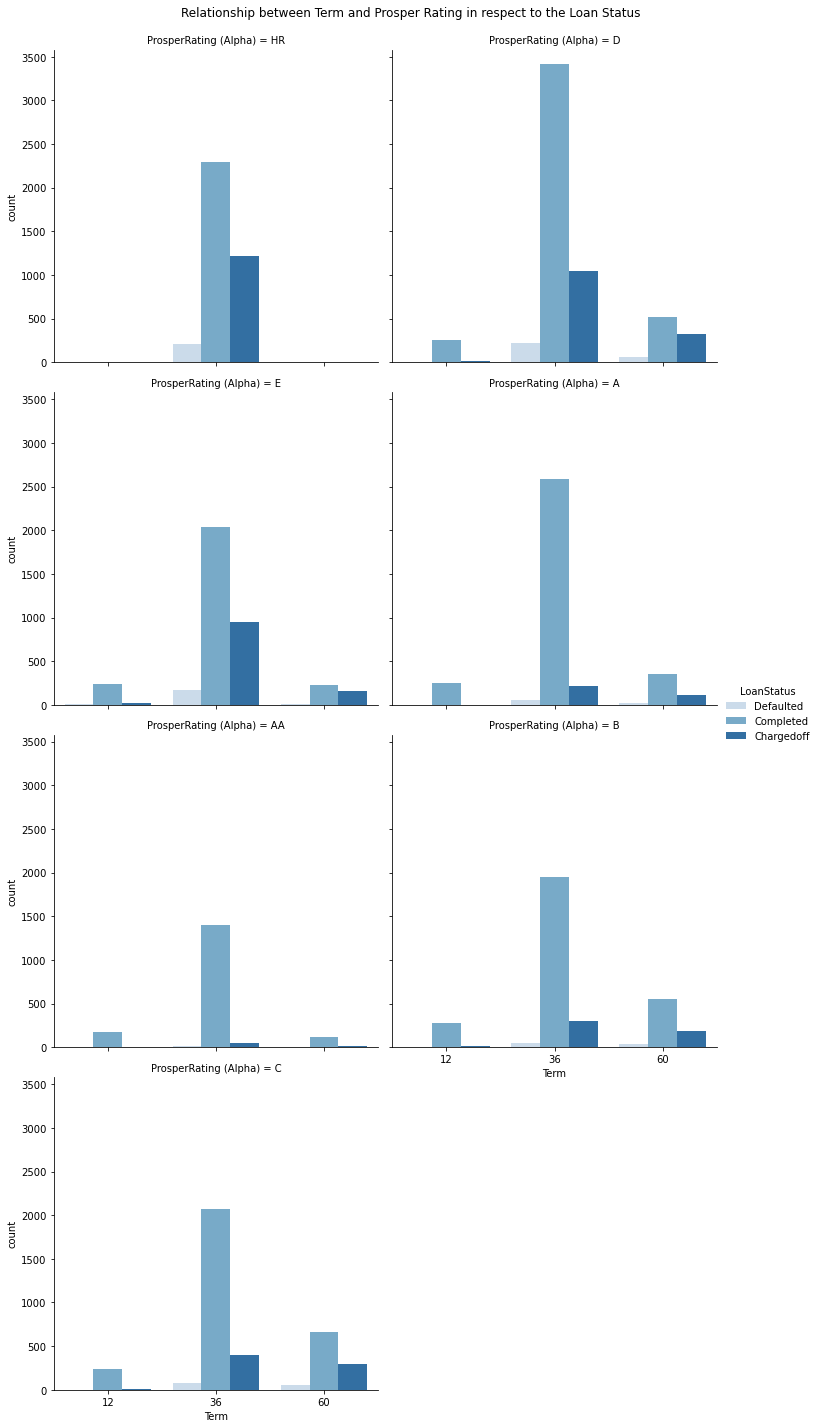

In [6]:
# Graphing the Term and the ProsperRating in respect to the LoanStatus

g = sb.catplot(data=df_sub2, x='Term', hue='LoanStatus', col='ProsperRating (Alpha)', kind='count', col_wrap=2,
           palette = 'Blues');
g.fig.subplots_adjust(top = 0.95)
g.fig.suptitle("Relationship between Term and Prosper Rating in respect to the Loan Status");

# Summary of Findings
The relationships observed from the previous graphs are as follows:
* The most important features in whether a borrower will default on a loan or not are the ProperRating/Score, Term and State.
* The better the Rating the less likley the borrower is going to default on loans, where borrowers with the D rating having the highest chance of defaulting on loans.
* The longer the term the more likley the borrower is going to default on loans.
* Borrowers from California being the most likeley to default on loans.